### New Version of dataraw_full_matrix

In [1]:
from collections import defaultdict, Counter
import numpy as np
import itertools
import copy
from util_distribution import report_countable_distribution
import matplotlib.pyplot as plt

In [2]:
ATTRIBUTES = {
    'color': ['red', 'green', 'blue'],
    'fill': ['void', 'dashed', 'solid'],
    'shape': ['square', 'circle', 'triangle'],
    'config': ['OOO', 'OOX', 'OXO']
}

ATTR_ORDER = ['color', 'fill', 'shape', 'config']

num_attributes = 4
num_attr_vals = 3
num_cards_per_query = 2

In [3]:
def decode_key_to_vocab_token(num_attributes, num_attr_vals, key_idx, null_vocab_idx):
    '''
    convert key_idx into vocab tokens for training
    '''
    # per attribute e.g. for 4 attr, 16 attr vals (10, 15, 5, 15)
    key_properties = decode_key_idx(num_attributes, num_attr_vals, key_idx)
    return decode_key_properties_to_vocab_token(num_attributes, num_attr_vals, key_properties, null_vocab_idx)

def encode_vocab_token_to_key(num_attributes, num_attr_vals, vocab_tokens, null_vocab_idx):
    '''
    reverse decode_key_to_vocab_token()
    '''
    key_properties = encode_vocab_token_to_key_properties(num_attributes, num_attr_vals, vocab_tokens, null_vocab_idx)
    key_idx = encode_key_idx(num_attributes, num_attr_vals, key_properties)
    return key_idx

def decode_key_properties_to_vocab_token(num_attributes, num_attr_vals, key_properties, null_vocab_idx):
    '''
    key_properties: np array. e.g. for 4 attr, 16 attr vals (10, 15, 5, 15)
    '''
    # (0*16, 1*16, 2*16, 3*16)
    key_range_indices = np.arange(num_attributes) * num_attr_vals
    if key_properties.size == 0:
        # null card
        vocab_tokens = np.array([null_vocab_idx] * num_attributes)
    else:
        # according to vocab e.g. for 4 attr, 16 attr vals (0*16+10=10, 1*16+15=31, 2*16+5=37, 3*16+15=63)
        vocab_tokens = key_range_indices + key_properties
    return vocab_tokens

def encode_vocab_token_to_key_properties(num_attributes, num_attr_vals, vocab_tokens, null_vocab_idx):
    '''
    reverse of decode_key_properties_to_vocab_token()
    '''
    assert isinstance(vocab_tokens, np.ndarray), 'vocab tokens should be type np.ndarray'
    # (0*16, 1*16, 2*16, 3*16)
    key_range_indices = np.arange(num_attributes) * num_attr_vals
    if set(vocab_tokens) == {null_vocab_idx}:
        key_properties = np.array([])
    else:
        key_properties = vocab_tokens - key_range_indices
    return key_properties

def decode_key_idx(num_attributes, num_attr_vals, key_idx):
    '''
    decode card idx into attr val indices
    '''
    assert key_idx <= num_attr_vals ** num_attributes, (key_idx)
    key_properties = []
    if key_idx == num_attr_vals ** num_attributes:
        return np.array([])
    else:
        card_idx_copy = key_idx
        for i in range(num_attributes):
            digit = card_idx_copy % num_attr_vals
            key_properties = [digit] + key_properties
            card_idx_copy = card_idx_copy // num_attr_vals
        assert len(key_properties) == num_attributes
        return np.array(key_properties)
    
def encode_key_idx(num_attributes, num_attr_vals, key_properties):
    '''
    reverse of decode_key_idx()
    '''
    key_properties = list(key_properties)

    if not key_properties:
        return num_attr_vals ** num_attributes
    else:
        key_idx = 0
        digit = 0
        while key_properties:
            attr_val = key_properties.pop()
            key_idx += attr_val * (num_attr_vals**digit)
            digit += 1
    return key_idx

In [4]:
def decode_query_idx_to_key_properties(num_attributes, num_attr_vals, num_cards_per_query, query_idx):
    query_parts_idx = decode_query_idx(num_attributes, num_attr_vals, num_cards_per_query, query_idx)
    return [decode_key_idx(num_attributes, num_attr_vals, idx) for idx in query_parts_idx]

def decode_query_idx(num_attributes, num_attr_vals, num_cards_per_query, query_idx):
    '''
    decode query_idx into individual card indices
    '''
    num_cards_minus_null = num_attr_vals ** num_attributes
    assert query_idx < num_cards_minus_null ** num_cards_per_query
    query_parts_idx = []
    query_idx_copy = query_idx
    for i in range(num_cards_per_query):
        digit = query_idx_copy % num_cards_minus_null
        query_parts_idx = [digit] + query_parts_idx
        query_idx_copy = query_idx_copy // num_cards_minus_null
    assert len(query_parts_idx) == num_cards_per_query
    return np.array(query_parts_idx)

assert (decode_query_idx(num_attributes, num_attr_vals, num_cards_per_query=2, query_idx=100) == np.array([1,19])).all()
assert (decode_query_idx(num_attributes, num_attr_vals, num_cards_per_query=3, query_idx=1) == np.array([0, 0, 1])).all()
assert (decode_query_idx(num_attributes, num_attr_vals, num_cards_per_query=3, query_idx=82) == np.array([0, 1, 1])).all()
assert (decode_query_idx(num_attributes, num_attr_vals, num_cards_per_query=3, query_idx=531439) == np.array([80, 80, 79])).all()
assert (decode_query_idx(num_attributes, num_attr_vals, num_cards_per_query=3, query_idx=531440) == np.array([80, 80, 80])).all()

def encode_query_idx(num_attributes, num_attr_vals, num_cards_per_query, query_parts_idx, queryidx_base=None):
    '''
    reverse decode_query_idx()
    query_parts_idx: a list of card indices
    base: np.array([81**2, 81**1, 81**0 ...])
    '''
    assert isinstance(query_parts_idx, np.ndarray)
    assert num_cards_per_query == len(query_parts_idx)
    num_cards_minus_null = num_attr_vals ** num_attributes
    if not queryidx_base:
        queryidx_base = np.array([num_cards_minus_null**i for i in reversed(range(num_cards_per_query))])
    query_idx = sum(query_parts_idx * queryidx_base)    
    assert query_idx < num_cards_minus_null ** num_cards_per_query
    return query_idx

assert (encode_query_idx(num_attributes, num_attr_vals, num_cards_per_query=2, query_parts_idx=np.array([1,19])) == 100).all()
assert (encode_query_idx(num_attributes, num_attr_vals, num_cards_per_query=3, query_parts_idx=np.array([0,0,1])) == 1).all()
assert (encode_query_idx(num_attributes, num_attr_vals, num_cards_per_query=3, query_parts_idx=np.array([0,1,1])) == 82).all()
assert (encode_query_idx(num_attributes, num_attr_vals, num_cards_per_query=3, query_parts_idx=np.array([80,80,79])) == 531439).all()
assert (encode_query_idx(num_attributes, num_attr_vals, num_cards_per_query=3, query_parts_idx=np.array([80,80,80])) == 531440).all()

In [5]:
# query_idx to query parts

# 

In [50]:
def check_if_query_key_match(num_attributes, num_attr_vals, query_parts, key, game_rule_fn):
    '''
    query_parts: such as [array([0, 0, 0, 0]), array([0, 0, 0, 0]), array([0, 0, 0, 0])]
    key: properties. such as [array([0, 0, 0, 1])]
    '''
    # rule 2 - 3 cards   
    pattern01 = query_parts[0] == query_parts[1]
    pattern12 = query_parts[1] == query_parts[2]
    patternQ = pattern01 == pattern12
    if key.size == 0:
        if np.sum(patternQ) == 0:
            return 1
        else:
            return 0
    patternK = query_parts[1] == key
    fil = patternQ
    match = (patternQ.astype(int)[fil] == patternK.astype(int)[fil]).all()  
    return match
    
    
#     # rule 3    
#     pattern1 = query_parts[0] == query_parts[1]
#     if key.size == 0:
#         if np.sum(pattern1) == 0:
#             return 1
#         else:
#             return 0
#     pattern2 = query_parts[1] == key
#     pattern3 = query_parts[0] == key
#     match = (pattern2 | pattern3).all()  
#     return match
    
#     # rule 2     
#     pattern1 = query_parts[0] == query_parts[1]
#     if key.size == 0:
#         if np.sum(pattern1) == 0:
#             return 1
#         else:
#             return 0
#     pattern2 = query_parts[1] == key
#     fil = pattern1
#     match = (pattern1.astype(int)[fil] == pattern2.astype(int)[fil]).all()  
#     return match
    
#     return game_rule_fn(num_attributes, num_attr_vals, query_parts, key)
    
    
#     # rule 1
#     pattern1 = query_parts[0] == query_parts[1]
#     if key.size == 0:
#         if np.sum(pattern1) == 0:
#             return 1
#         else:
#             return 0
#     pattern2 = query_parts[1] == key
#     match = np.sum(pattern1 & pattern2)
#     return match


# def derive_ans_expression(query_parts):
#     '''
#     query_parts: a list of arrays. e.g. [array([0, 0, 0, 0]), array([0, 0, 0, 0]), array([0, 0, 0, 0])]
#     ''' 
#     # c0 ( c1 c2 ) c3 c4
    

def apply_game_rules_SET_long_queries(num_attributes, num_attr_vals, query_parts, key):
    '''multiple card queries'''
    assert key.size > 0 and num_attr_vals == 3
    # derive answer card from query
    gt_ans_card = derive_ans_expression(query_parts)
    match = (gt_ans_card == key).all()
    return match
    
#     check = lambda x: len(set(x)) == 1 or len(set(x)) == 3
#     checks = [check([query_parts[0][i], query_parts[1][i], key[i]]) for i in range(num_attributes)]
#     match = all(checks)
#     return match

def apply_game_rules_SET_short_queries(num_attributes, num_attr_vals, query_parts, key):
    '''Two card queries'''
    assert num_attr_vals == 3
#     assert key.size > 0 and num_attr_vals == 3
    check = lambda x: len(set(x)) == 1 or len(set(x)) == 3
    checks = [check([query_parts[0][i], query_parts[1][i], key[i]]) for i in range(num_attributes)]
    match = all(checks)
    return match

def check_if_query_key_match_by_idx(num_attributes, num_attr_vals, num_cards_per_query, query_idx, key_idx, game_rule_fn):
    '''return an int'''
    query_parts = decode_query_idx_to_key_properties(num_attributes, num_attr_vals, num_cards_per_query, query_idx)
    key = decode_key_idx(num_attributes, num_attr_vals, key_idx)
    return check_if_query_key_match(num_attributes, num_attr_vals, query_parts, key, game_rule_fn)

def construct_full_matrix(num_attributes, num_attr_vals, num_cards_per_query, game_rule_fn):
    num_keys = num_attr_vals ** num_attributes + 1
    num_queries = (num_keys-1) ** num_cards_per_query
    count_table = np.zeros((num_keys, num_queries))
    for k_idx in range(num_keys):
        for q_idx in range(num_queries):
            match = check_if_query_key_match_by_idx(num_attributes, num_attr_vals, num_cards_per_query, q_idx, k_idx, game_rule_fn)
            if match > 0:
                count_table[k_idx, q_idx] += 1
    tot_size = num_keys * num_queries
    sparsity = np.sum(count_table) * 1.0 / tot_size
    print('Constructed Full Matrix:')
    print(f'{num_keys} keys by {num_queries} queries')
    print(f'Total size {tot_size}')
    print(f'Sparsity {sparsity}')
    return count_table

# def report_svd(count_table):
#     xy = count_table / np.sum(count_table)
    
#     xy_div_xyind = 
    
#     np.linalg.matrix_rank(xy_div_xyind[:-1, :])

In [36]:
# rule 4
count_table = construct_full_matrix(num_attributes, num_attr_vals, num_cards_per_query, game_rule_fn=apply_game_rules_SET_short_queries)

Constructed Full Matrix:
82 keys by 6561 queries
Total size 538002
Sparsity 0.09650707618187293


In [36]:
# rule 3
count_table = construct_full_matrix(num_attributes, num_attr_vals, num_cards_per_query, game_rule_fn=apply_game_rules_SET_short_queries)

Constructed Full Matrix:
82 keys by 6561 queries
Total size 538002
Sparsity 0.09650707618187293


In [45]:
# rule 2
count_table = construct_full_matrix(num_attributes, num_attr_vals, num_cards_per_query, game_rule_fn=apply_game_rules_SET_short_queries)

Constructed Full Matrix:
82 keys by 6561 queries
Total size 538002
Sparsity 0.3638964167419452


In [51]:
# rule 2 - 3 cards query
count_table = construct_full_matrix(num_attributes=4, num_attr_vals=3, num_cards_per_query=3, game_rule_fn=apply_game_rules_SET_short_queries)

Constructed Full Matrix:
82 keys by 531441 queries
Total size 43578162
Sparsity 0.15571875197489973


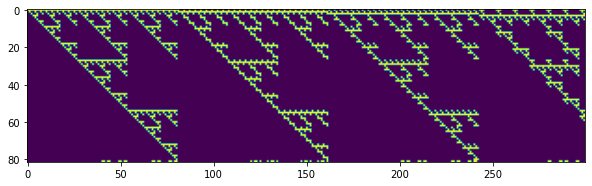

In [37]:
# rule 2 - 3 cards query
plt.figure(figsize=(10,15))
plt.imshow(count_table[:,:300])

In [ ]:
# rule 2 - 3 cards query
count_table, xy, xyind, xy_div_xyind, distribution = report_countable_distribution(count_table)
print(np.linalg.matrix_rank(xy_div_xyind[:-1, :]))
u, s, vh = np.linalg.svd(xy_div_xyind[:-1, :])
print(s)
plt.plot(s)

In [ ]:
# rule 2 - 3 cards query
Counter(np.sum(count_table, axis=0).tolist())

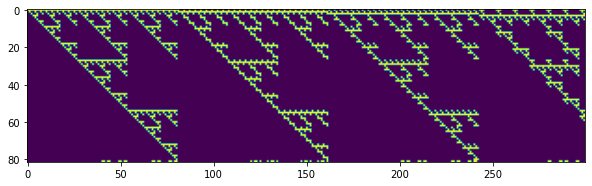

In [37]:
# rule 3
plt.figure(figsize=(10,15))
plt.imshow(count_table[:,:300])

In [42]:
# rule 3
Counter(np.sum(count_table, axis=0).tolist())

Counter({1.0: 81, 2.0: 648, 4.0: 1944, 8.0: 2592, 17.0: 1296})

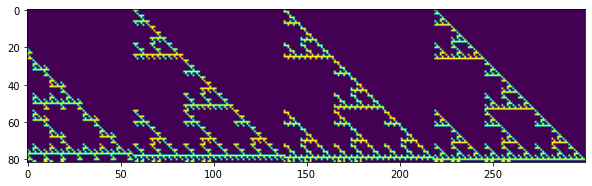

In [39]:
# rule 3
plt.figure(figsize=(10,15))
plt.imshow(count_table[:,-300:])

81
[739.18238721 525.68756546 525.68756546 525.68756546 525.68756546
 525.68756546 525.68756546 525.68756546 525.68756546 372.77571966
 372.77571966 372.77571966 372.77571966 372.77571966 372.77571966
 372.77571966 372.77571966 372.77571966 372.77571966 372.77571966
 372.77571966 372.77571966 372.77571966 372.77571966 372.77571966
 372.77571966 372.77571966 372.77571966 372.77571966 372.77571966
 372.77571966 372.77571966 372.77571966 263.96567166 263.96567166
 263.96567166 263.96567166 263.96567166 263.96567166 263.96567166
 263.96567166 263.96567166 263.96567166 263.96567166 263.96567166
 263.96567166 263.96567166 263.96567166 263.96567166 263.96567166
 263.96567166 263.96567166 263.96567166 263.96567166 263.96567166
 263.96567166 263.96567166 263.96567166 263.96567166 263.96567166
 263.96567166 263.96567166 263.96567166 263.96567166 263.96567166
 186.78380475 186.78380475 186.78380475 186.78380475 186.78380475
 186.78380475 186.78380475 186.78380475 186.78380475 186.78380475
 186.78

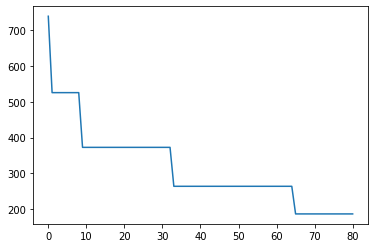

In [38]:
# rule 3
count_table, xy, xyind, xy_div_xyind, distribution = report_countable_distribution(count_table)
print(np.linalg.matrix_rank(xy_div_xyind[:-1, :]))
u, s, vh = np.linalg.svd(xy_div_xyind[:-1, :])
print(s)
plt.plot(s)

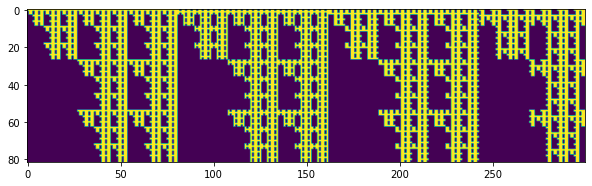

In [46]:
# rule 2
plt.figure(figsize=(10,15))
plt.imshow(count_table[:,:300])

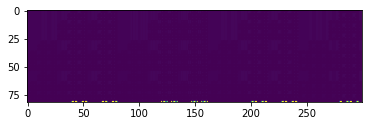

In [153]:
# rule 2
plt.imshow(xy_div_xyind[:,:300])

In [47]:
# rule 2
Counter(np.sum(count_table, axis=0).tolist())

Counter({1.0: 81, 3.0: 648, 9.0: 1944, 27.0: 2592, 82.0: 1296})

81
[732.09884671 423.6930999  423.6930999  423.6930999  423.6930999
 423.6930999  423.6930999  423.6930999  423.6930999  244.61932528
 244.61932528 244.61932528 244.61932528 244.61932528 244.61932528
 244.61932528 244.61932528 244.61932528 244.61932528 244.61932528
 244.61932528 244.61932528 244.61932528 244.61932528 244.61932528
 244.61932528 244.61932528 244.61932528 244.61932528 244.61932528
 244.61932528 244.61932528 244.61932528 141.2310333  141.2310333
 141.2310333  141.2310333  141.2310333  141.2310333  141.2310333
 141.2310333  141.2310333  141.2310333  141.2310333  141.2310333
 141.2310333  141.2310333  141.2310333  141.2310333  141.2310333
 141.2310333  141.2310333  141.2310333  141.2310333  141.2310333
 141.2310333  141.2310333  141.2310333  141.2310333  141.2310333
 141.2310333  141.2310333  141.2310333  141.2310333  141.2310333
  81.53977509  81.53977509  81.53977509  81.53977509  81.53977509
  81.53977509  81.53977509  81.53977509  81.53977509  81.53977509
  81.53977509  

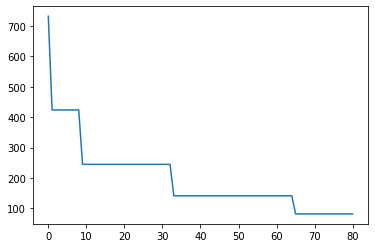

In [29]:
# rule 2
count_table, xy, xyind, xy_div_xyind, distribution = report_countable_distribution(count_table)
print(np.linalg.matrix_rank(xy_div_xyind[:-1, :]))
u, s, vh = np.linalg.svd(xy_div_xyind[:-1, :])
print(s)
plt.plot(s)

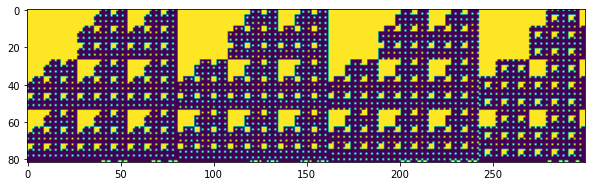

In [151]:
# rule 1
import matplotlib.pyplot as plt
plt.figure(figsize=(10,15))
plt.imshow(count_table[:,:300])

81
[657.28169548 260.38613132 260.38613132 260.38613132 260.38613132
 260.38613132 260.38613132 260.38613132 260.38613132  37.19114702
  37.19114702  37.19114702  37.19114702  37.19114702  37.19114702
  37.19114702  37.19114702  37.19114702  37.19114702  37.19114702
  37.19114702  37.19114702  37.19114702  37.19114702  37.19114702
  37.19114702  37.19114702  37.19114702  37.19114702  37.19114702
  37.19114702  37.19114702  37.19114702   6.56619619   6.56619619
   6.56619619   6.56619619   6.56619619   6.56619619   6.56619619
   6.56619619   6.56619619   6.56619619   6.56619619   6.56619619
   6.56619619   6.56619619   6.56619619   6.56619619   6.56619619
   6.56619619   6.56619619   6.56619619   6.56619619   6.56619619
   6.56619619   6.56619619   6.56619619   6.56619619   6.56619619
   6.56619619   6.56619619   6.56619619   6.56619619   6.56619619
   1.25424247   1.25424247   1.25424247   1.25424247   1.25424247
   1.25424247   1.25424247   1.25424247   1.25424247   1.25424247
   1.25

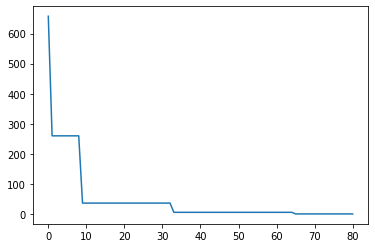

In [154]:
# rule 1
print(np.linalg.matrix_rank(xy_div_xyind[:-1, :]))
u, s, vh = np.linalg.svd(xy_div_xyind[:-1, :])
print(s)
plt.plot(s)

In [ ]:
# Rules

# multiple query parts
# simple key

# set


# existence
# count
# optimize

In [ ]:
# First, hold the num attr and attr val the same -- same number of key cards
# Try to make the game more difficult like this.

# Hold num query cards at 2 for now.
# Does using AND rules increase the rank? -- should be harder?
# Does using set rules increase the rank? -- should be even harder?